<a href="https://colab.research.google.com/github/mawildoer/energy/blob/main/snippets/energy_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pull resources
!pip install geopandas rasterio

# Get our repo
!git clone https://github.com/mawildoer/energy

# Install LFS hooks and get content
!sudo apt-get install git-lfs
%cd energy
!git lfs install
!git lfs pull
%cd ../

# Pull Our World in Data
!git clone https://github.com/owid/owid-datasets/

     |████████████████████████████████| 1.0MB 3.7MB/s 
     |████████████████████████████████| 19.1MB 198kB/s 
     |████████████████████████████████| 15.3MB 15.4MB/s 
     |████████████████████████████████| 6.5MB 21.4MB/s 
Cloning into 'energy'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 8), reused 26 (delta 5), pack-reused 0
Unpacking objects: 100% (34/34), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe 

In [ ]:
import attr

import pandas as pd
import geopandas as gp

import numpy as np

import rasterio
import rasterio.plot
import rasterio.features
import rasterio.warp

from matplotlib import pyplot

In [ ]:
dataset = rasterio.open('/content/energy/energy/data/gpw_v4_population_density_rev11_2000_2pt5_min.tif')
pop_den = dataset.read(1, masked=True)
pop_den.mask = np.logical_or(pop_den.mask, pop_den < 1)
crs = dataset.crs
transform = dataset.transform

In [ ]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world = world.to_crs(dataset.crs)

In [ ]:
@attr.s
class CoordSys:
  crs = attr.ib()
  transform = attr.ib(default=None)
  raster_shape = attr.ib(default=None)
  project = None

  @classmethod
  def from_rasterio(cls, data):
    return cls(str(data.crs), data.transform, dataset.shape)

@attr.s
class Raster:
  crd: CoordSys = attr.ib()
  array: np.ndarray = attr.ib()

  @property
  def crs(self):
    return crd.crs

  @property
  def transform(self):
    return crd.transform

  @property
  def shape(self):
    return raster.shape

  @classmethod
  def from_geopandas(cls, df, series, shape=None, crd=None, stacking_func=None):
    """Create a raster from a geopandas dataframe."""
    if shape is None and crd.raster_shape is None:
      raise ValueError("The shape must be specified either through the coordinate system or the shape argument. Neither is specified.")
    shape = shape if shape else crd.raster_shape  # default to explict shape

    raster = cls(crd, np.ma.zeros(shape))
    raster.array[:] = np.ma.masked

    if df.crs != crd.crs:
      df = df.to_crs(crd.crs)

    for i, row in df.iterrows():
      mask = rasterio.features.geometry_mask([row.geometry], shape, crd.transform)
      raster.array.mask[mask] = False  # Do not mask off these regions, as we now have valid data there

      if stacking_func is None:
        raster.array[mask] = row[series]
      else:
        stacking_func(raster.array[mask], row[series])  # Could be a numpy add or similar

    raster.array[raster.array.mask] = np.nan

    return raster

  def destory_masked(self, inplace=True):
    if inplace:
      out = self.array
    else:
      out = self.array.copy()
    out[self.array.mask] = np.nan
    return out
      

  def reproject(self, crd, inplace=False):
    if self.crs == crd.crs and self.transform == crd.transform:
      if crd.raster_shape is not None:
        if self.shape == crd.raster_shape:
          return self 
    
    with rasterio.Env():
        source = self.destory_masked(inplace)
        dest = np.full(crd.raster_shape, np.nan)

        rasterio.warp.reproject(
          source,
          dest,
          src_transform=self.transform,
          src_crs=self.crs,
          dst_transform=crd.transform,
          dst_crs=crd.crs, 
          resampling=rasterio.warp.Resampling.nearest)

    @classmethod
    def from_rasterio(cls, data_reader: rasterio.DatasetReader, crd=None, band=1):
      """Create a raster from a rasterio DatasetReader."""
      raise NotImplemented() #if data_reader.

Raster(crd=CoordSys(crs='EPSG:4326', transform=Affine(0.0416666666666667, 0.0, -180.0,
       0.0, -0.0416666666666667, 89.99999999999994), raster_shape=(4320, 8640)), array=masked_array(
  data=[[18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0],
        [18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0],
        [18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0],
        ...,
        [18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0],
        [18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0],
        [18560000.0, 18560000.0, 18560000.0, ..., 18560000.0, 18560000.0,
         18560000.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., Fal

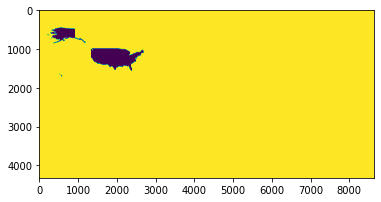

In [ ]:
CoordSys.project = CoordSys.from_rasterio(dataset)
gdp = Raster.from_geopandas(world.head(), "gdp_md_est", crd=CoordSys.project)
print(gdp)
pyplot.imshow(gdp.array)

In [ ]:
dataset.shape

(4320, 8640)

In [ ]:
CoordSys.project.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
world.get_transform

<bound method DataFrame.transform of        pop_est  ...                                           geometry
0       920938  ...  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1     53950935  ...  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2       603253  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3     35623680  ...  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4    326625791  ...  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...
..         ...  ...                                                ...
172    7111024  ...  POLYGON ((18.82982 45.90887, 18.82984 45.90888...
173     642550  ...  POLYGON ((20.07070 42.58863, 19.80161 42.50009...
174    1895250  ...  POLYGON ((20.59025 41.85541, 20.52295 42.21787...
175    1218208  ...  POLYGON ((-61.68000 10.76000, -61.10500 10.890...
176   13026129  ...  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...

[177 rows x 6 columns]>

In [ ]:
rasterio.crs.CRS.from_string(str(CoordSys.project.crs))

CRS.from_epsg(4326)

In [ ]:
str(world.iloc[0].geometry)

'MULTIPOLYGON (((180 -16.06713266364245, 180 -16.5552165666392, 179.3641426619641 -16.80135407694688, 178.7250593629971 -17.01204167436804, 178.5968385951171 -16.63915, 179.0966093629971 -16.4339842775474, 179.4135093629971 -16.3790542775474, 180 -16.06713266364245)), ((178.12557 -17.50481, 178.3736 -17.33992, 178.71806 -17.62846, 178.55271 -18.15059, 177.93266 -18.28799, 177.38146 -18.16432, 177.28504 -17.72465, 177.67087 -17.38114, 178.12557 -17.50481)), ((-179.7933201090486 -16.02088225674122, -179.9173693847653 -16.5017831356494, -180 -16.5552165666392, -180 -16.06713266364245, -179.7933201090486 -16.02088225674122)))'

In [ ]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
